In [2]:
import pandas as pd
import numpy as np
import os
import re
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.impute import KNNImputer
from scipy import stats
from statsmodels.stats.multitest import multipletests

c:\Users\cw2019\.conda\envs\py10\lib\site-packages\numpy\_distributor_init.py:30: UserWarning: loaded more than 1 DLL from .libs:
c:\Users\cw2019\.conda\envs\py10\lib\site-packages\numpy\.libs\libopenblas.EL2C6PLE4ZYW3ECEVIV3OXXGRN2NRFM2.gfortran-win_amd64.dll
c:\Users\cw2019\.conda\envs\py10\lib\site-packages\numpy\.libs\libopenblas64__v0.3.23-246-g3d31191b-gcc_10_3_0.dll
  warnings.warn("loaded more than 1 DLL from .libs:"


In [122]:

class MetabolonDataset:
    '''
    Class to load and QC metabolon data
    '''
    def __init__(self, file_path, id, node_name, first_row_index, first_col_index, identifiers_row, md_sampname, md_group, md_filter):
        self.file_path = file_path
        self.raw_data = None
        self.compound_mappers = None
        self.processed_data = None
        self.metadata = None
        self.id = id
        self.node_name = node_name
        self.first_row_index = first_row_index
        self.first_col_index = first_col_index
        self.identifiers_row = identifiers_row
        self.md_sampname = md_sampname
        self.md_group = md_group
        self.md_filter = md_filter
        self.DA_metabolites = None

        self.read_data(file_path)
        self.preprocess_data()
        
    def read_data(self, file_path):
        """
        Read in the metabolon data
        """
        # read in the data
        data = pd.read_excel(file_path + '/peaktable.xlsx', header=None)
        self.raw_data = data

        metadata = pd.read_csv(file_path + '/s_' + self.id + '.txt', sep = '\t')

        self.metadata = metadata
        print(metadata[[self.md_sampname, self.md_group]])
        return data, metadata

    def preprocess_data(self):
        data_filt = self.raw_data.copy()
        data_filt.index = data_filt.iloc[:, 0]
        data_filt.columns = data_filt.iloc[self.identifiers_row, :].astype(str)
        data_filt = data_filt.iloc[self.first_row_index:, self.first_col_index:]

        # Transpose
        data_filt = data_filt.T

        # Missingness checks 
        # Delete colums and rows where all values are missing
        data_filt = data_filt.dropna(axis=0, how='all')
        data_filt = data_filt.dropna(axis=1, how='all')

        data_filt = data_filt.dropna(axis=1, thresh=0.3*data_filt.shape[0])
        missing_pct = data_filt.isnull().sum().sum() / (data_filt.shape[0] * data_filt.shape[1]) * 100

        # impute missing values
        imputer = KNNImputer(n_neighbors=2, weights="uniform").set_output(transform="pandas")
        data_imputed = imputer.fit_transform(data_filt)

        # log transformation
        data_imputed = np.log(data_imputed + 1)

        # standardize
        scaler = StandardScaler().set_output(transform="pandas")
        data_scaled = scaler.fit_transform(data_imputed)

        # add metadata column
        md_dict = dict(zip(self.metadata[self.md_sampname], self.metadata[self.md_group]))
        data_scaled['Group'] = data_scaled.index.map(md_dict)

        # filter on metadata
        # TODO check whether to rescale after filtering
        data_scaled = data_scaled[data_scaled['Group'].isin(self.md_filter)]

        self.processed_data = data_scaled

        return data_scaled
    
    def plot_qc(self):
        
        # PCA biplot
        pca = PCA(n_components=2)
        pca_result = pca.fit_transform(self.processed_data.iloc[:, :-1])

        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
        sns.scatterplot(
            x=pca_result[:, 0], y=pca_result[:, 1],
            hue="Group",
            data=self.processed_data,
            alpha=0.7,
            ax=ax1
        )

        # normality every nth feature
        normaliser = (self.processed_data.shape[1] - 1) / 20
        sns.boxplot(data=self.processed_data.iloc[:, ::50], ax=ax2)
        plt.show()

    def da_testing(self):

        # t-test for two groups
        groups = self.processed_data['Group'].unique()
        stat, pvals = stats.ttest_ind(self.processed_data[self.processed_data['Group'] == groups[0]].iloc[:, :-1],
                        self.processed_data[self.processed_data['Group'] == groups[1]].iloc[:, :-1],
                        alternative='two-sided')
        pval_df = pd.DataFrame(pvals, index=self.processed_data.columns[:-1], columns=['P-value'])

        # fdr correction 
        pval_df['FDR_P-value'] = multipletests(pvals, method='fdr_bh')[1]

        # return significant metabolites
        self.DA_metabolites = pval_df[pval_df['FDR_P-value'] < 0.05].index.tolist()

        # generate tuples for nx links
        self.connection = [(self.node_name, met) for met in self.DA_metabolites]
    


In [87]:

pmh_data = MetabolonDataset(
    file_path = 'MTBLS136', 
    id = 'MTBLS136', 
    node_name = 'PMH', 
    first_row_index=4, 
    first_col_index=9, 
    identifiers_row=1,
    md_sampname='Sample Name',
    md_group='Factor Value[CurrentPMH]',
    md_filter=['Nonuser', 'E-only']
    )


     Sample Name Factor Value[CurrentPMH]
0      063459_01                  Nonuser
1      081531_03                   E-only
2     022817_136                      NaN
3      079243_03                  Nonuser
4      034993_02                   E-only
...          ...                      ...
1644   009987_03                   E-only
1645   011337_01                      NaN
1646   061443_03                   E-only
1647   039714_01                      NaN
1648   022781_02                   E-only

[1649 rows x 2 columns]


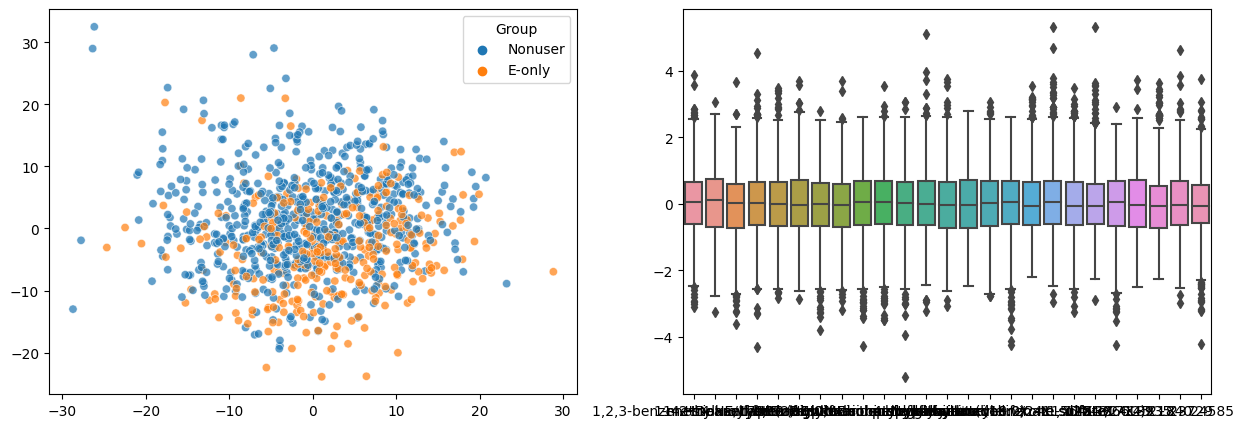

In [22]:
pmh_data.plot_qc()

In [74]:
pmh_data.da_testing()

In [129]:
preterm_data = MetabolonDataset(
    file_path = 'MTBLS702',
    id = 'MTBLS702',
    node_name = 'Preterm',
    first_row_index=2,
    first_col_index=6,
    identifiers_row=1,
    md_sampname='Sample Name',
    md_group='Factor Value[Race]',
    md_filter=['Black', 'White']
    )


    Sample Name Factor Value[Race]
0    UNPA-02736              Black
1    UNPA-02740              Black
2    UNPA-02745              Black
3    UNPA-02749              Black
4    UNPA-02750              Black
..          ...                ...
120  UNPA-02999              Black
121  UNPA-03000              White
122  UNPA-03001              Black
123  UNPA-03002              Black
124  UNPA-03005              White

[125 rows x 2 columns]


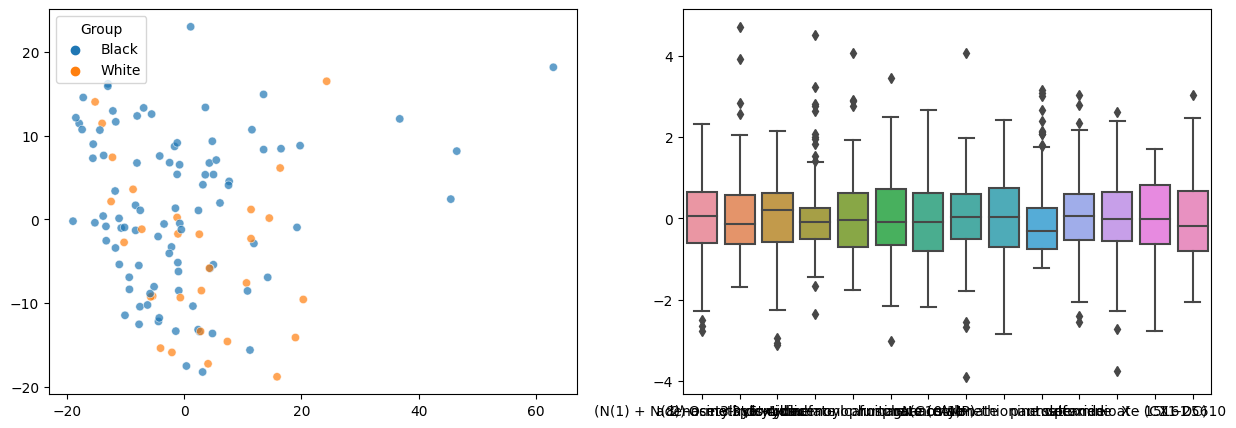

In [130]:
preterm_data.plot_qc()
preterm_data.da_testing()

In [131]:
preterm_data.DA_metabolites

['1-methylhistamine',
 '1-oleoyl-2-linoleoyl-GPC (18:1/18:2)*',
 '1-stearoyl-2-oleoyl-GPS (18:0/18:1)',
 '3-hydroxypyridine sulfate',
 '3-methylxanthine',
 'cysteine-glutathione disulfide',
 'glycosyl-N-palmitoyl-sphingosine (d18:1/16:0)',
 'hypotaurine',
 'lignoceroyl sphingomyelin (d18:1/24:0)',
 'margaroylcarnitine (C17)*',
 'myristoylcarnitine (C14)',
 'oleoylcarnitine (C18:1)',
 'palmitoyl sphingomyelin (d18:1/16:0)',
 'palmitoylcarnitine (C16)',
 'quinate',
 'sphingomyelin (d17:1/16:0, d18:1/15:0, d16:1/17:0)*',
 'stearoylcarnitine (C18)',
 'theobromine',
 'hydroxyproline',
 'tryptamine',
 'vanillic acid glycine',
 'X - 15161']

In [88]:

sct_data = MetabolonDataset(
    file_path = 'MTBLS406', 
    id = 'MTBLS406', 
    node_name = 'Stem cell transplant', 
    first_row_index = 3, 
    first_col_index = 6, 
    identifiers_row=1,
    md_sampname='Source Name',
    md_group = 'Factor Value[Gender]',
    md_filter=['Male', 'Female']
    )

        Source Name Factor Value[Gender]
0    BG111_24_02_14                 Male
1    ME114_24_02_14               Female
2    GD112_25_02_14                 Male
3    BG111_10_03_14                 Male
4    ME114_10_03_14               Female
..              ...                  ...
588      1_CUC23972                 Male
589      1_CUC25149                 Male
590      1_CUC25793                  NaN
591        1_CUC573                  NaN
592       1_CUC6159                  NaN

[593 rows x 2 columns]


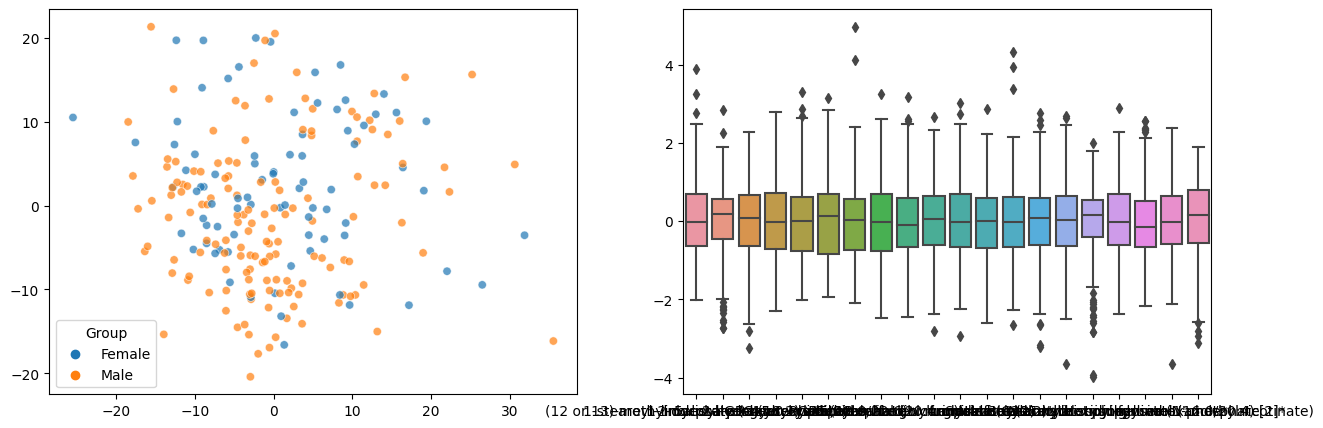

In [17]:
sct_data.plot_qc()

In [89]:
sct_data.da_testing()

In [90]:
pmh_data.da_testing()

In [26]:
import networkx as nx

In [125]:
preterm_data.connection

[('Preterm', 'diethanolamine')]

In [132]:
from networkx.algorithms import bipartite
B = nx.Graph()
# Add nodes with the node attribute "bipartite"
B.add_nodes_from([sct_data.node_name, pmh_data.node_name, preterm_data.node_name], bipartite=0)
B.add_nodes_from(sct_data.DA_metabolites + pmh_data.DA_metabolites + preterm_data.DA_metabolites, bipartite=1)
# Add edges only between nodes of opposite node sets
B.add_edges_from(sct_data.connection + pmh_data.connection + preterm_data.connection)

In [133]:
bottom_nodes, top_nodes = bipartite.sets(B)

In [134]:
nx.is_connected(B)

True

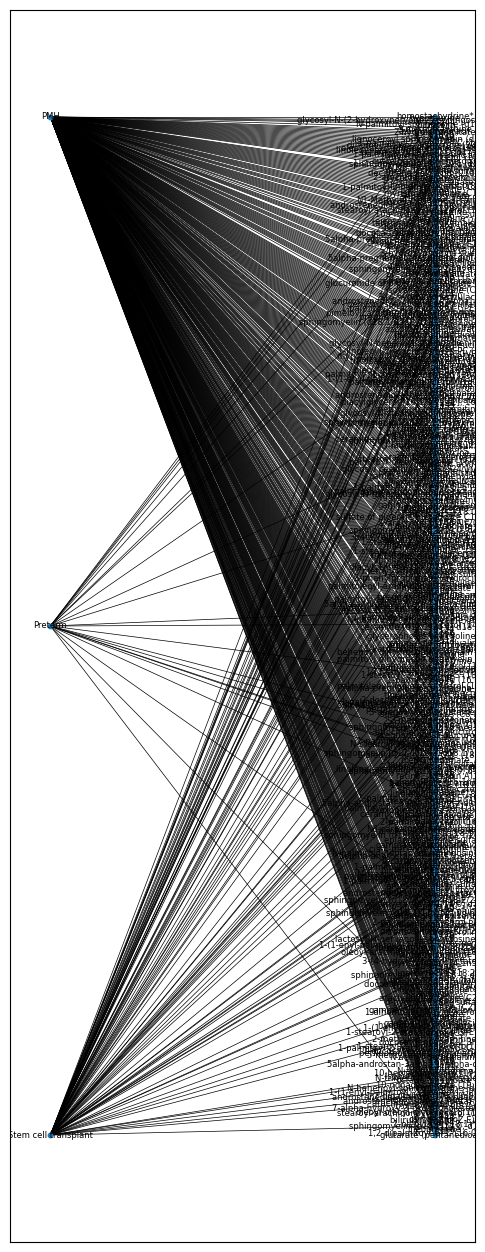

In [135]:
plt.figure(3,figsize=(6,16)) 
nx.draw_networkx(
    B,
    pos = nx.drawing.layout.bipartite_layout(B, bottom_nodes),
    font_size=6,
    width = 0.5,
    with_labels=True,
    node_size=10,
    ) # Or whatever other display options you like

plt.show()